# **📄 Document type classification baseline code**
> 문서 타입 분류 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 ResNet 모델을 로드하여, 모델을 학습 및 예측 파일 생성하는 프로세스에 대해 알아보겠습니다.

## Contents
- Prepare Environments
- Import Library & Define Functions
- Hyper-parameters
- Load Data
- Train Model
- Inference & Save File


## 1. Prepare Environments

* 데이터 로드를 위한 구글 드라이브를 마운트합니다.
* 필요한 라이브러리를 설치합니다.

In [1]:
# # 구글 드라이브 마운트, Colab을 이용하지 않는다면 패스해도 됩니다.
# from google.colab import drive
# drive.mount('/gdrive', force_remount=True)
# drive.mount('/content/drive')

Mounted at /gdrive
Mounted at /content/drive


In [5]:
# 대회 데이터를 압축 해제하고 로컬에 저장합니다.
!tar -xvf data.tar.gz > /dev/null

In [3]:
!pip install timm

  Using cached timm-1.0.8-py3-none-any.whl.metadata (53 kB)
Using cached timm-1.0.8-py3-none-any.whl (2.3 MB)



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
!pip install albumentations

  Using cached albumentations-1.4.12-py3-none-any.whl.metadata (38 kB)
     ---------------------------------------- 0.0/60.9 kB ? eta -:--:--
     ------------ ------------------------- 20.5/60.9 kB 330.3 kB/s eta 0:00:01
     -------------------------------------- 60.9/60.9 kB 649.5 kB/s eta 0:00:00
  Using cached pydantic-2.8.2-py3-none-any.whl.metadata (125 kB)
  Using cached albucore-0.0.12-py3-none-any.whl.metadata (3.1 kB)
  Using cached eval_type_backport-0.2.0-py3-none-any.whl.metadata (2.2 kB)
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     ---------------------------------------- 61.0/61.0 kB 3.2 MB/s eta 0:00:00
Using cached albumentations-1.4.12-py3-none-any.whl (171 kB)
Using cached albucore-0.0.12-py3-none-any.whl (8.4 kB)
   ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
   - -------------------------------------- 0.5/15.8 MB 10.0 MB/

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
anaconda-cloud-auth 0.1.4 requires pydantic<2.0, but you have pydantic 2.8.2 which is incompatible.


In [1]:
!pip install -r requirements.txt

  Using cached Flask-1.0.2-py2.py3-none-any.whl.metadata (4.2 kB)
  Using cached Pillow-7.2.0.tar.gz (39.1 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached loguru-0.5.3-py3-none-any.whl.metadata (21 kB)
  Using cached matplotlib-3.1.1.tar.gz (37.8 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached numpy-1.19.5-cp39-cp39-win_amd64.whl.metadata (2.0 kB)
  Using cached pandas-1.1.1.tar.gz (5.2 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'


  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [323 lines of output]
      Ignoring numpy: markers 'python_version == "3.6" and platform_system != "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.7" and platform_system != "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.6" and platform_system == "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.7" and platform_system == "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version >= "3.8" and platform_system == "AIX"' don't match your environment
        Using cached setuptools-72.1.0-py3-none-any.whl.metadata (6.6 kB)
        Using cached wheel-0.43.0-py3-none-any.whl.metadata (2.2 kB)
        Using cached Cython-0.29.37-py2.py3-none-any.whl.metadata (3.1 kB)
        Using cached numpy-1.17.3.zip (6.4 MB)
    

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [2]:
import os
import time
import random

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

c:\Users\jsy61\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,
INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [3]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [4]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None, suffix=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform
        self.suffix = suffix

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        # Add the suffix to the file name if specified
        if self.suffix:
            base_name, ext = os.path.splitext(name)
            name = f"{base_name}{self.suffix}{ext}"
        img_path = os.path.join(self.path, name)
        img = np.array(Image.open(img_path))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

In [5]:
img_size = 1000
LR = 1e-3
EPOCHS = 1
BATCH_SIZE = 32
num_workers = 0

In [6]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# augmentation을 위한 transform 코드
trn_transform = A.Compose([
    ## 긴 쪽을 img_size에 맞추고 비율 유지
    #A.LongestMaxSize(max_size=img_size),
    ## 나머지 부분을 패딩으로 채움
    #A.PadIfNeeded(min_height=img_size, min_width=img_size,
    #              border_mode=0, value=(0,0,0)),  # 검은색으로 패딩
    ## images normalization
    #A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # numpy 이미지나 PIL 이미지를 PyTorch 텐서로 변환
    ToTensorV2(),
])

# test image 변환을 위한 transform 코드
tst_transform = A.Compose([
    #A.LongestMaxSize(max_size=img_size),
    #A.PadIfNeeded(min_height=img_size, min_width=img_size,
    #              border_mode=0, value=(0,0,0)),
    #A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [23]:
# Dataset 정의
trn_dataset = ImageDataset(
    "data/train.csv",
    "data/train/",
    transform=trn_transform,
    suffix= None
)
tst_dataset = ImageDataset(
    "data/sample_submission.csv",
    "data/test_processed/",
    transform=tst_transform,
    suffix='_processed'
)
print(len(trn_dataset), len(tst_dataset))

1570 3140


In [8]:
# DataLoader 정의
trn_loader = DataLoader(
    trn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)
tst_loader = DataLoader(
    tst_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [10]:
!pip install koreanize_matplotlib

   ---------------------------------------- 0.0/7.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.9 MB 682.7 kB/s eta 0:00:12
   - -------------------------------------- 0.2/7.9 MB 3.1 MB/s eta 0:00:03
   --- ------------------------------------ 0.7/7.9 MB 6.7 MB/s eta 0:00:02
   ------ --------------------------------- 1.3/7.9 MB 8.1 MB/s eta 0:00:01
   --------- ------------------------------ 1.8/7.9 MB 8.8 MB/s eta 0:00:01
   ----------- ---------------------------- 2.3/7.9 MB 9.3 MB/s eta 0:00:01
   -------------- ------------------------- 2.8/7.9 MB 9.6 MB/s eta 0:00:01
   ----------------- ---------------------- 3.4/7.9 MB 10.3 MB/s eta 0:00:01
   ------------------- -------------------- 3.9/7.9 MB 10.4 MB/s eta 0:00:01
   ---------------------- ----------------- 4.5/7.9 MB 10.6 MB/s eta 0:00:01
   ------------------------- -------------- 5.0/7.9 MB 10.6 MB/s eta 0:00:01
   --------------------------- ------------ 5.5/7.9 MB 10.7 MB/s eta 0:00:01
   ---------

Training Dataset:


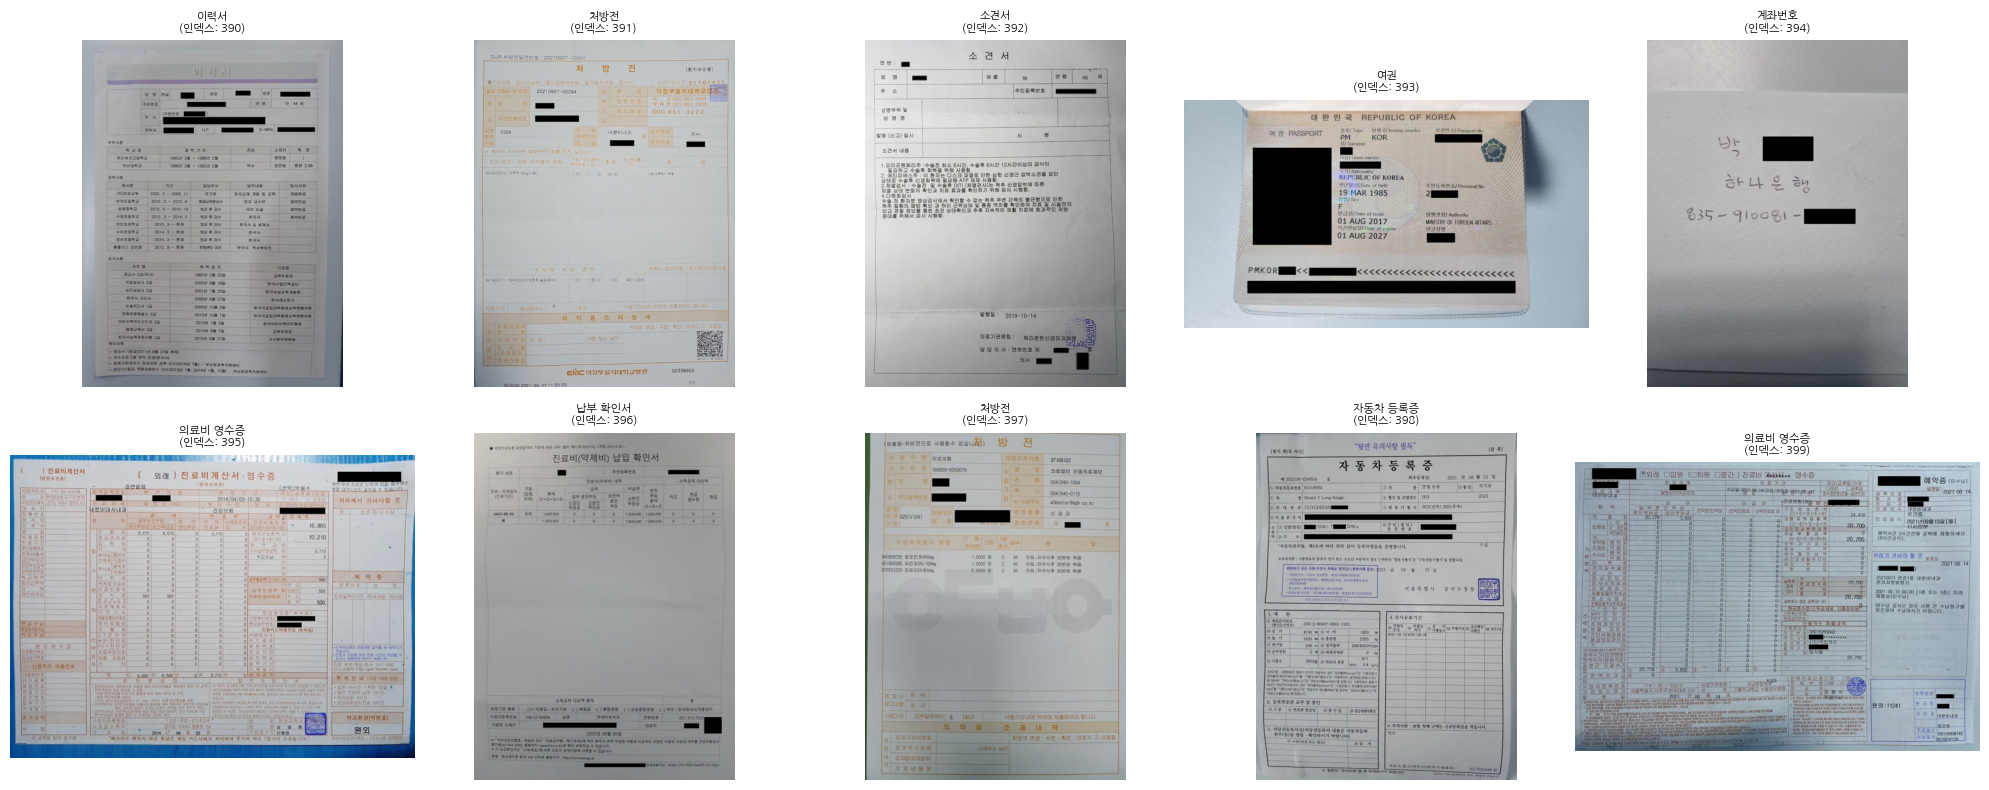

전체 데이터셋의 라벨 분포:
차량 번호판: 100 (6.37%)
납부 확인서: 100 (6.37%)
계좌번호: 100 (6.37%)
입퇴원 확인서: 100 (6.37%)
처방전: 100 (6.37%)
주민등록증: 100 (6.37%)
자동차 대시보드: 100 (6.37%)
약국 영수증: 100 (6.37%)
외래 진료 확인서: 100 (6.37%)
여권: 100 (6.37%)
자동차 등록증: 100 (6.37%)
운전면허증: 100 (6.37%)
진단서: 100 (6.37%)
의료비 영수증: 100 (6.37%)
이력서: 74 (4.71%)
소견서: 50 (3.18%)
임신 의료비 지급 신청서: 46 (2.93%)


In [11]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
import koreanize_matplotlib



# 시각화 함수 (변경 없음)
class_mapping = {
    0: "계좌번호", 1: "임신 의료비 지급 신청서", 2: "자동차 대시보드", 3: "입퇴원 확인서",
    4: "진단서", 5: "운전면허증", 6: "의료비 영수증", 7: "외래 진료 확인서", 8: "주민등록증",
    9: "여권", 10: "납부 확인서", 11: "약국 영수증", 12: "처방전", 13: "이력서",
    14: "소견서", 15: "자동차 등록증", 16: "차량 번호판"
}

def visualize_dataset(dataset, set_number=1, num_images=10, is_train=True):
    total_images = len(dataset)
    start_index = (set_number - 1) * num_images
    end_index = min(start_index + num_images, total_images)
    
    # 이미지와 라벨 가져오기
    images = []
    labels = []
    
    for i in range(start_index, end_index):
        img, label = dataset[i]
        images.append(img)
        labels.append(label)
    
    # 그리드 생성을 위한 figure 설정
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for i, (img, label) in enumerate(zip(images, labels)):
        # 이미지 표시 (정규화 해제 없이)
        img_np = img.permute(1, 2, 0).numpy()
        axes[i].imshow(img_np)
        axes[i].axis('off')
        actual_index = start_index + i
        
        if is_train:
            # 라벨 표시 (훈련 데이터인 경우)
            class_name = class_mapping.get(label, f"알 수 없는 클래스 {label}")
            axes[i].set_title(f"{class_name}\n(인덱스: {actual_index})", fontsize=8)
        else:
            axes[i].set_title(f"인덱스: {actual_index}")
    
    # 남은 축 제거
    for i in range(len(images), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()
    
    if is_train:
        # 전체 데이터셋의 라벨 분포 출력
        all_labels = [dataset[i][1] for i in range(total_images)]
        label_counts = pd.Series(all_labels).value_counts()
        
        print("전체 데이터셋의 라벨 분포:")
        for label, count in label_counts.items():
            class_name = class_mapping.get(label, f"알 수 없는 클래스 {label}")
            print(f"{class_name}: {count} ({count/total_images*100:.2f}%)")

# 훈련 데이터셋 시각화
print("Training Dataset:")
visualize_dataset(trn_dataset, set_number=40)


In [135]:
# 훈련 데이터셋 시각화
print("Training Dataset:")
visualize_dataset(trn_dataset, set_number=40)

Training Dataset:


FileNotFoundError: [Errno 2] No such file or directory: 'data/train/3f3667f946bde615_processed.jpg'

In [12]:
# 테스트 데이터셋 시각화
print("test Dataset:")
visualize_dataset(tst_dataset, set_number=7)

test Dataset:


FileNotFoundError: [Errno 2] No such file or directory: 'data/test_processed2/06427235c81111cc_processed.jpg'

In [20]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)

        model.zero_grad(set_to_none=True)

        preds = model(image)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [13]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = 'data'

# model config
model_name = 'resnet34' # 'resnet50' 'efficientnet-b0', ...

# training config
img_size = 32
LR = 1e-3
EPOCHS = 1
BATCH_SIZE = 32
num_workers = 0

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [14]:
# augmentation을 위한 transform 코드
trn_transform = A.Compose([
    # 이미지 크기 조정
    A.Resize(height=img_size, width=img_size),
    # images normalization
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # numpy 이미지나 PIL 이미지를 PyTorch 텐서로 변환
    ToTensorV2(),
])

# test image 변환을 위한 transform 코드
tst_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [26]:
# Dataset 정의
trn_dataset = ImageDataset(
    "data/train.csv",
    "data/train/",
    transform=trn_transform
)
tst_dataset = ImageDataset(
    "data/sample_submission.csv",
    "data/test_processed/",
    transform=tst_transform
)
print(len(trn_dataset), len(tst_dataset))

1570 3140


In [25]:
# DataLoader 정의
trn_loader = DataLoader(
    trn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)
tst_loader = DataLoader(
    tst_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

In [17]:
# load model
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet34.a1_in1k)


model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

c:\Users\jsy61\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jsy61\.cache\huggingface\hub\models--timm--resnet34.a1_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
INFO:timm.models._hub:[timm/resnet34.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensor

In [21]:
for epoch in range(EPOCHS):
    ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device=device)
    ret['epoch'] = epoch

    log = ""
    for k, v in ret.items():
      log += f"{k}: {v:.4f}\n"
    print(log)

Loss: 2.2840: 100%|██████████| 50/50 [00:23<00:00,  2.10it/s]

train_loss: 2.4318
train_acc: 0.2771
train_f1: 0.2429
epoch: 0.0000



# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [27]:
preds_list = []

model.eval()
for image, _ in tqdm(tst_loader):
    image = image.to(device)

    with torch.no_grad():
        preds = model(image)
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

100%|██████████| 99/99 [00:22<00:00,  4.33it/s]


In [31]:
# Assuming pred_df is your DataFrame containing the predictions
pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list

# Remove '_processed' suffix from the IDs in pred_df
pred_df['ID'] = pred_df['ID'].str.replace('_processed', '')



In [32]:
# Load the sample submission DataFrame
sample_submission_df = pd.read_csv("data/sample_submission.csv")

# Ensure the IDs match for assertion
assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [33]:
pred_df.to_csv("pred_testsetonlyprocessed_white.csv", index=False)

In [34]:
pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,8
1,00091bffdffd83de.jpg,12
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,9
4,00901f504008d884.jpg,2


In [35]:
pred_df['target'].value_counts()

9     948
0     420
16    402
5     326
8     228
12    195
2     159
4     103
6      77
10     60
15     57
11     53
7      46
3      43
13     21
14      1
1       1
Name: target, dtype: int64